In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
sns.set_style('whitegrid')

## Correlogram Plot

In [18]:
def plot_correlogram(
    x, 
    lags=None, 
    title=None,
    acf_ylim=None, 
    pacf_ylim=None,
    acf_xlim=None, 
    pacf_xlim=None
):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

    # Residual plot
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

    # QQ plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1,2,3,4])
    s = (f"Mean: {mean:>12.2f}\n"
         f"SD: {np.sqrt(var):>16.2f}\n"
         f"Skew: {skew:12.2f}\n"
         f"Kurtosis:{kurtosis:9.2f}")
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    # ACF
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    if acf_ylim is not None:
        axes[1][0].set_ylim(acf_ylim)
    if acf_xlim is not None:
        axes[1][0].set_xlim(acf_xlim)

    # PACF
    plot_pacf(x=x, lags=lags, zero=False, ax=axes[1][1])
    if pacf_ylim is not None:
        axes[1][1].set_ylim(pacf_ylim)
    if pacf_xlim is not None:
        axes[1][1].set_xlim(pacf_xlim)

    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Crpyto Index Data

We will use daily BTC returns from march 23, 2023

In [19]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from sklearn.manifold import MDS
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, modularity



input_dir = 'data/'

In [20]:
symbols = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'DOGEUSDT']

In [21]:
candlestick_cols = [
    "Open time",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close time",
    "Quote asset volume",
    "Number of trades",
    "Taker buy base asset volume",
    "Taker buy quote asset volume",
    "Ignore"
]

In [22]:
def get_sorted_cols(cols):
    # Convert names → indices
    pairs = [(name, candlestick_cols.index(name)) for name in cols]

    # Sort by the index
    pairs_sorted = sorted(pairs, key=lambda x: x[1])

    # Extract sorted names and indices
    sorted_names  = [name for name, idx in pairs_sorted]
    sorted_indices = [idx for name, idx in pairs_sorted]

    return sorted_names, sorted_indices

In [23]:
def load_series(symbol, cols):
    time_serieses = []

    sorted_names, sorted_indices = get_sorted_cols(cols)
    col_names = [f'{symbol}_{name}' for name in sorted_names]
    df = pd.read_csv(
            os.path.join(input_dir, f"{symbol}.csv"),
            usecols=[0, *sorted_indices],
            header = None,
            names=["time", *col_names]
        )
    df.loc[df["time"] >= 1e15, "time"] = df["time"] // 1000
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[df["time"] >= pd.Timestamp('2023-03-24 14:00:00')]
    for name in col_names:
        s = pd.Series(
            df[name].values,
            index = df["time"],
            name = name
        )
        time_serieses.append(s)
    return time_serieses

### IMPORTANT ###
### IMPORTANT ###
### IMPORTANT ###

load_dataframes function takes in n symbols and the m column indices, and returns a tuple of m dataframes, each with n columns corresponding to the requested symbols. For example, load_dataframes(['BTCUSDT', 'ETHUSDT'], ['Open', "Quote asset volume"]) will return two dataframes: the first containing the 'Open' prices for BTCUSDT, ETHUSDT and the second containing the 'Quote asset volume' for the same symbols. Don't pass in "Open time" as this will automatically as the index

In [24]:
def load_dataframes(symbol_subset, cols):
    dfs = [[] for _ in cols]
    for symbol in symbol_subset:
        time_serieses = load_series(symbol, cols)
        for i, time_series in enumerate(time_serieses):
            dfs[i].append(time_series)
    for i, col_index in enumerate(cols):
        dfs[i] = pd.concat(dfs[i], axis=1)
    return dfs

price, = load_dataframes(['BTCUSDT'], ['Open'])

In [25]:
daily_btc = price['BTCUSDT_Open']

In [26]:
daily_btc_log = np.log(daily_btc)

In [27]:
daily_btc_log_diff = daily_btc_log.diff().dropna()

## Explore Returns and Volatility

The rescaled daily return series exhibits only limited autocorrelation, but the squared deviations from the mean do have substantial memory reflected in the slowly-decaying ACF and the PACF high for the first two and cutting off only after the first six lags:

The function plot_correlogram produces the following output:

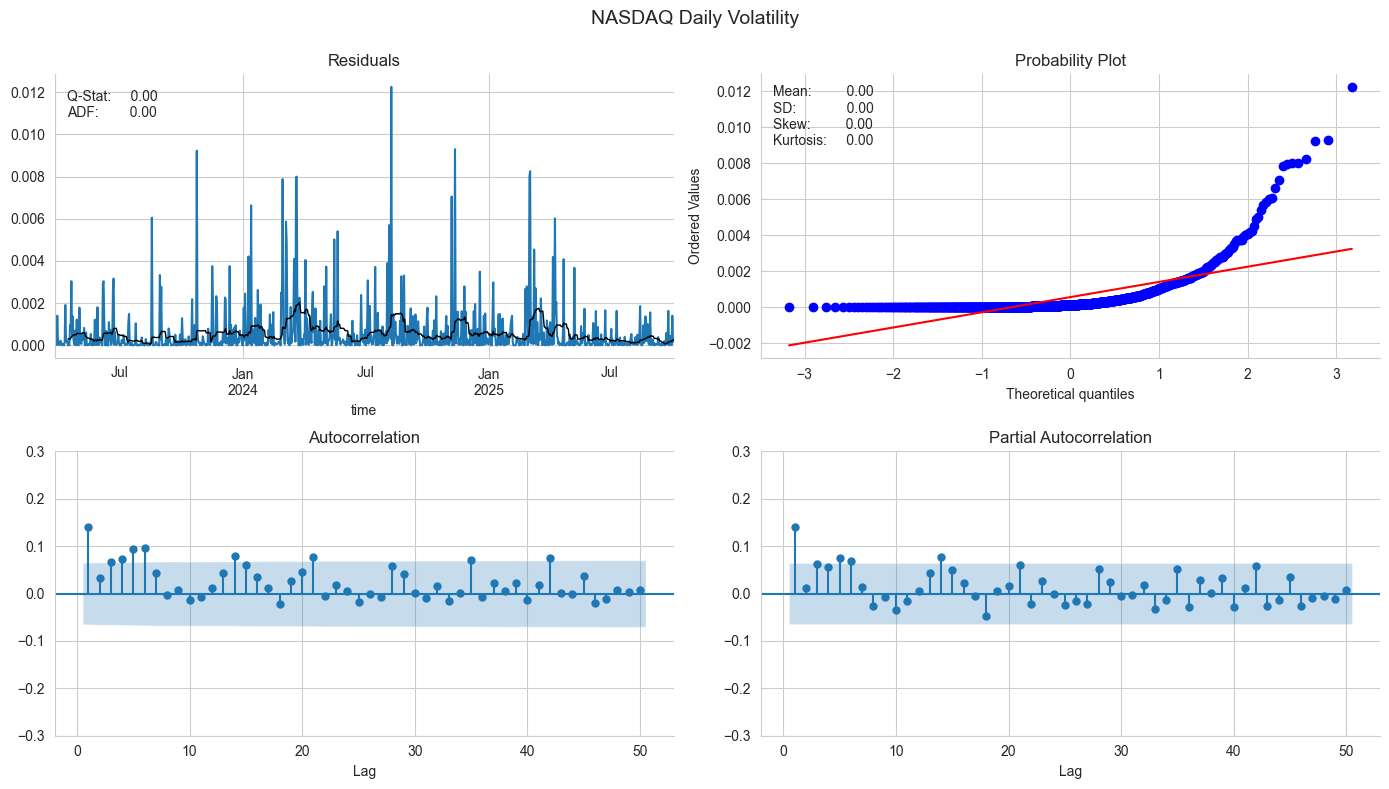

In [28]:
plot_correlogram(daily_btc_log_diff.sub(daily_btc_log_diff.mean()).pow(2), lags=50, title='NASDAQ Daily Volatility', acf_ylim=(-0.3, 0.3), pacf_ylim=(-0.3, 0.3))